  0%|          | 0/3 [00:00<?, ?it/s]/home/ljq/code/Ringdown_gap_filling/Proj/data/data_generation.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(original_signal), torch.tensor([Mtot, M_ratio, R_shift])
/home/ljq/code/Ringdown_gap_filling/Proj/data/data_generation.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(original_signal), torch.tensor([Mtot, M_ratio, R_shift])
/home/ljq/code/Ringdown_gap_filling/Proj/data/data_generation.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return t

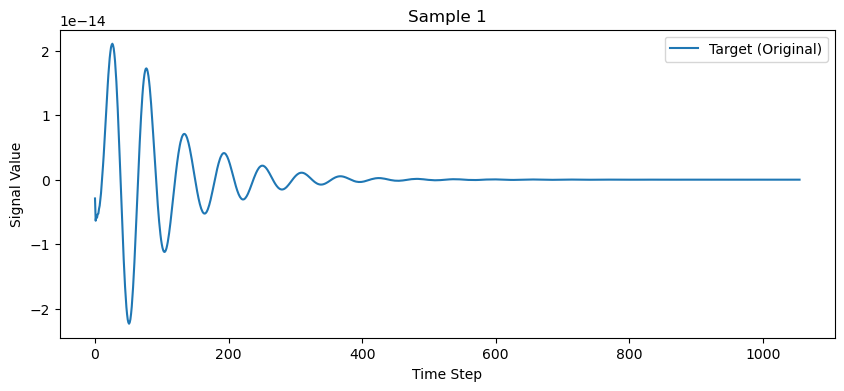

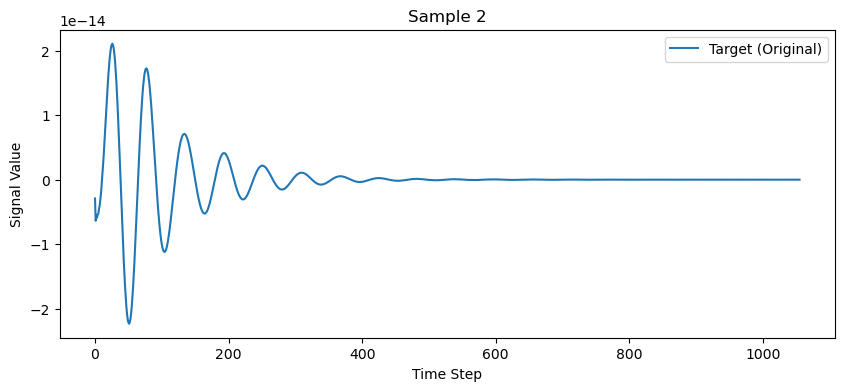

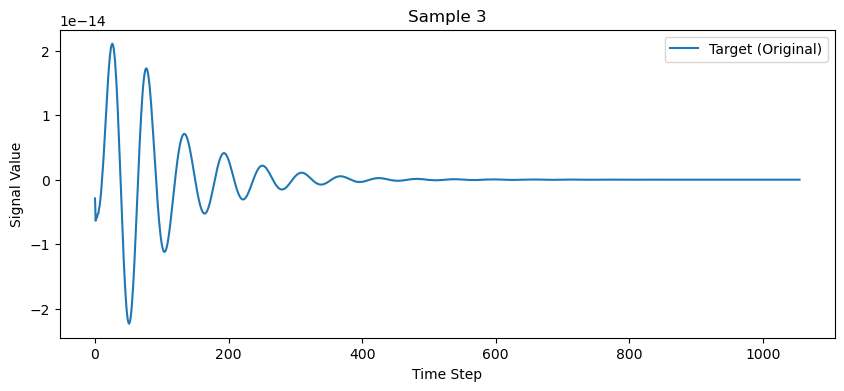

In [ ]:
from config.config import Config
import numpy as np
from data.data_generation import generate_data_
import matplotlib.pyplot as plt

num_samples_to_plot = 3
signals, conditions = generate_data(
        num_samples=num_samples_to_plot
    )

targets=signals
# 要绘制的样本数量
for i in range(num_samples_to_plot):
    plt.figure(figsize=(10, 4))
    #plt.plot(inputs[i], label='Input (Masked)')
    plt.plot(targets[i], label='Target (Original)')
    plt.title(f'Sample {i+1}')
    plt.xlabel('Time Step')
    plt.ylabel('Signal Value')
    plt.legend()
    plt.show()
 

In [15]:
import torch
from torch.utils.data import DataLoader
from config.config import Config
from data.data_generation import generate_data
from dataset.dataset import GWSignalDatasetForDecomposition
#from model.mymodel import MaskedConditionalAutoencoder
from model.mymodel_2 import MaskedConditionalGapFiller
from trainer.trainer import train_the_model
from utils.visualization import visualize_waveform
from utils.normalize import normalize
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import numpy as np
from utils.mask import generate_continuous_mask
from utils.wavelet import wavelet_bandpass
from utils.segment import segment_signal
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# def estimate_physical_parameters(signal):
#     """
#     估计信号的物理参数，例如频率、相位和振幅。
#     这是一个简单的示例实现，具体实现应根据你的需求进行调整。
#     """
#     # 假设信号是一个简单的正弦波，我们可以估计它的幅度、频率和相位
#     amplitude = signal.abs().max().item()  # 估计振幅
#     frequency = torch.fft.fftfreq(signal.size(0)).abs().argmax().item()  # 估计频率
#     phase = torch.atan2(signal[1], signal[0]).item()  # 估计相位

#     return [amplitude, frequency, phase]
 



 

# 生成训练集数据
#freq_ifft = np.arange(Config.f_in,Config.fout,Config.f_step)

signal_length=Config.signal_length
gap_size = signal_length//Config.signal_to_gap_length_ratio


data = np.load('data/signal_data_for_mode_decomposition.npz')
#data = np.load('data/test_signal_data.npz')
signals = data['signals']
signals_22=data['signals_22']
signals_21=data['signals_21']
signals_33=data['signals_33']
signals_44=data['signals_44']
conditions = data['conditions']
#signal,condition=generate_data(1)
# signals=[]
# signal=signal.transpose(0,1)
# print(signal.shape)
# for _ in range(Config.num_samples):
    
#     signals.append(signal)

# #masked_signals = data['masked_signals']

# conditions=[]
# print(condition.shape)
# condition=condition.transpose(1,0)
# for _ in range(Config.num_samples):
    
#     conditions.append(condition)


#数据预处理
#n_signals,mean,std=normalize(signals)
signals = torch.tensor(signals, dtype=torch.float32)
signals_22 = torch.tensor(signals_22, dtype=torch.float32)
signals_21 = torch.tensor(signals_21, dtype=torch.float32)
signals_33 = torch.tensor(signals_33, dtype=torch.float32)
signals_44 = torch.tensor(signals_44, dtype=torch.float32)
signals_copy=signals

signals,_,_=normalize(signals)
signals_22,_,_=normalize(signals_22)
signals_21,_,_=normalize(signals_21)
signals_33,_,_=normalize(signals_33)
signals_44,_,_=normalize(signals_44)
signals=torch.tensor(signals, dtype=torch.float32)

processed_signals = []
print(len(signals[0]))
print(signals[0].shape)

for signal in signals:
    # 对原始信号进行小波变换和分段
    transformed_signal = wavelet_bandpass(signal)
    segmented_signal = segment_signal(transformed_signal)

    processed_signals.append(segmented_signal)



dataset = GWSignalDatasetForDecomposition(signals,processed_signals,signals_22,signals_21,signals_33,signals_44, conditions)








/home/ljq/code/Ringdown_gap_filling/Proj/utils/normalize.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  signal=torch.tensor(signal)
/tmp/ipykernel_11204/786305993.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  signals=torch.tensor(signals, dtype=torch.float32)


1056
torch.Size([1056])


In [16]:
torch.save(dataset, 'dataset_decomposition.pt')

In [17]:
import torch
from torch.utils.data import DataLoader
from config.config import Config
from data.data_generation import generate_data
from dataset.dataset import GWSignalDataset
#from model.mymodel import MaskedConditionalAutoencoder
from model.mymodel_3 import AutoEncoderModeDecomposer
from trainer.trainer import train_the_model_decomposition
from utils.visualization import visualize_waveform
from utils.normalize import normalize
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import numpy as np
from utils.mask import generate_continuous_mask
from utils.wavelet import wavelet_bandpass
from utils.segment import segment_signal
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loaded_dataset = torch.load('dataset_decomposition.pt')
dataset=loaded_dataset
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

batch_size = Config.batch_size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 获取一个批次的数据
_,inputs,targets22,targets21,targets33,targets44, conditions = next(iter(train_loader))

#打印形状
print(f'Inputs shape: {inputs.shape}')  
print(f'Targets shape: {targets22.shape}')  
print(f'Conditions shape: {targets21.shape}')
print(f'Conditions shape: {targets33.shape}')
print(f'Conditions shape: {targets44.shape}')
print(f'Conditions shape: {conditions.shape}')  

import matplotlib.pyplot as plt

# 可视化第一个批次中的前几个样本
# num_samples_to_plot = 3  # 要绘制的样本数量
# for i in range(num_samples_to_plot):
#     plt.figure(figsize=(10, 4))
#     plt.plot(inputs[i].cpu().numpy(), label='Input (Masked)')
#     plt.plot(targets[i].cpu().numpy(), label='Target (Original)')
#     plt.title(f'Sample {i+1}')
#     plt.xlabel('Time Step')
#     plt.ylabel('Signal Value')
#     plt.legend()
#     plt.show()

# 定义模型  
model=AutoEncoderModeDecomposer().to(device)
train_the_model_decomposition(
    model,
    train_loader,
    val_loader,
    num_epochs=Config.num_epochs,
    learning_rate=Config.learning_rate,
    save_path_decomposition=Config.model_save_path_decomposition,
    device=device,
    save_freq=10
)


/home/ljq/code/Ringdown_gap_filling/Proj/dataset/dataset.py:151: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(signal, dtype=torch.float32),
/home/ljq/code/Ringdown_gap_filling/Proj/dataset/dataset.py:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(signal_22, dtype=torch.float32),
/home/ljq/code/Ringdown_gap_filling/Proj/dataset/dataset.py:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(signal_21, dtype=torch.float32),
/home/ljq/code/Ringdown_gap_filling/Proj/dataset/dataset.py:155: UserWarning

Inputs shape: torch.Size([16, 8, 32, 64])
Targets shape: torch.Size([16, 1056])
Conditions shape: torch.Size([16, 1056])
Conditions shape: torch.Size([16, 1056])
Conditions shape: torch.Size([16, 1056])
Conditions shape: torch.Size([16, 3])


/home/ljq/miniconda3/envs/few_env/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
/home/ljq/code/Ringdown_gap_filling/Proj/dataset/dataset.py:151: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(signal, dtype=torch.float32),
/home/ljq/code/Ringdown_gap_filling/Proj/dataset/dataset.py:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(signal_22, dtype=torch.float32),
/home/ljq/code/Ringdown_gap_filling/Proj/dataset/dataset.py:154: UserWarning: To copy construct from a te

200
Epoch [1/200], Training Loss: 277.4588, Validation Loss: 334.9386
Epoch [2/200], Training Loss: 236.7871, Validation Loss: 272.6394
Epoch [3/200], Training Loss: 200.4588, Validation Loss: 227.3844
Epoch [4/200], Training Loss: 170.3101, Validation Loss: 183.1992
Epoch [5/200], Training Loss: 140.7497, Validation Loss: 141.4420
Epoch [6/200], Training Loss: 119.6410, Validation Loss: 138.9765
Epoch [7/200], Training Loss: 105.9146, Validation Loss: 105.0348
Epoch [8/200], Training Loss: 95.0336, Validation Loss: 94.5662
Epoch [9/200], Training Loss: 85.1522, Validation Loss: 86.1164
Epoch [10/200], Training Loss: 80.1571, Validation Loss: 82.7943
Model saved to ./saved_models/model_decomposition_epoch_10
Epoch [11/200], Training Loss: 71.1865, Validation Loss: 74.0878
Epoch [12/200], Training Loss: 67.1257, Validation Loss: 73.4385
Epoch [13/200], Training Loss: 63.1799, Validation Loss: 76.4968
Epoch [14/200], Training Loss: 60.2441, Validation Loss: 66.7545
Epoch [15/200], Traini

KeyboardInterrupt: 

In [18]:
import torch
from config.config import Config
from utils.mask import generate_continuous_mask
import torch
from torch.utils.data import DataLoader
from config.config import Config
from data.data_generation import generate_data_for_mode_decomposition
from dataset.dataset import GWSignalDataset
#from model.mymodel import MaskedConditionalAutoencoder
from model.mymodel_3 import AutoEncoderModeDecomposer
from trainer.trainer import train_the_model
from utils.visualization import visualize_waveform
from utils.normalize import normalize
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import numpy as np
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 测试阶段

# def estimate_physical_parameters(signal):
signal_length=Config.signal_length
gap_size = signal_length//Config.signal_to_gap_length_ratio
model = AutoEncoderModeDecomposer().to(device)
#model_path = '/home/ljq/code/Ringdown_gap_filling/Proj/saved_models/model.pth'
model.load_state_dict(torch.load('./saved_models/model_decomposition.pth'))

# 切换到评估模式
model.eval()

test_num=50


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

test_signals, test_22_signals,test_21_signals,test_33_signals,test_44_signals, test_conditions = generate_data_for_mode_decomposition(
        num_samples=test_num
    )
test_signals_copy=test_signals
test_signals,mean_0,std_0=normalize(test_signals)
test_22_signals,mean_22,std_22=normalize(test_22_signals)
test_21_signals,mean_21,std_21=normalize(test_21_signals)
test_33_signals,mean_33,std_33=normalize(test_33_signals)
test_44_signals,mean_44,std_44=normalize(test_44_signals)
#masked_test_signals_tensor = torch.tensor(n_masked_test_signals, dtype=torch.float32).unsqueeze(-1).to(device)
#zero_conditions_tensor = torch.zeros((test_signals_tensor.size(0), Config.condition_dim)).to(device)



  0%|          | 0/50 [00:00<?, ?it/s]/home/ljq/code/Ringdown_gap_filling/Proj/data/data_generation.py:157: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(original_signal),torch.tensor(signal_22),torch.tensor(signal_21),torch.tensor(signal_33),torch.tensor(signal_44),torch.tensor([Mtot, M_ratio, R_shift])
/home/ljq/code/Ringdown_gap_filling/Proj/data/data_generation.py:157: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(original_signal),torch.tensor(signal_22),torch.tensor(signal_21),torch.tensor(signal_33),torch.tensor(signal_44),torch.tensor([Mtot, M_ratio, R_shift])
/home/ljq/code/Ringdown_gap_filling/Proj/data/data_generation.py:157: UserWarning:

In [19]:
from utils.wavelet import wavelet_bandpass
from utils.segment import segment_signal


processed_test_signals = []


for signal in test_signals:
    # 对原始信号进行小波变换和分段
    transformed_signal = wavelet_bandpass(signal)
    segmented_signal = segment_signal(transformed_signal)



    processed_test_signals.append(segmented_signal)


# 转换为张量
processed_test_signals_tensor = torch.tensor(processed_test_signals, dtype=torch.float32).to(device)

<class 'numpy.ndarray'>


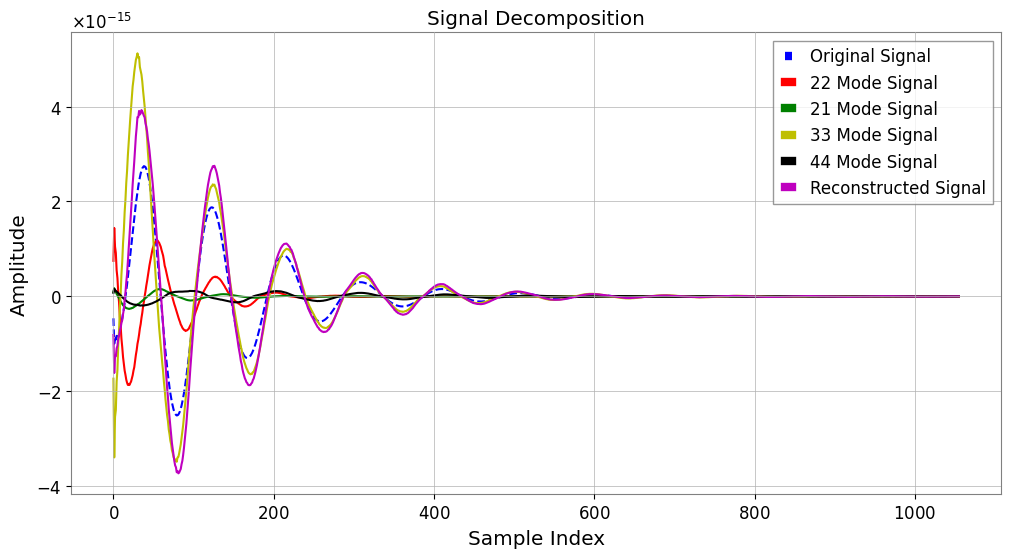

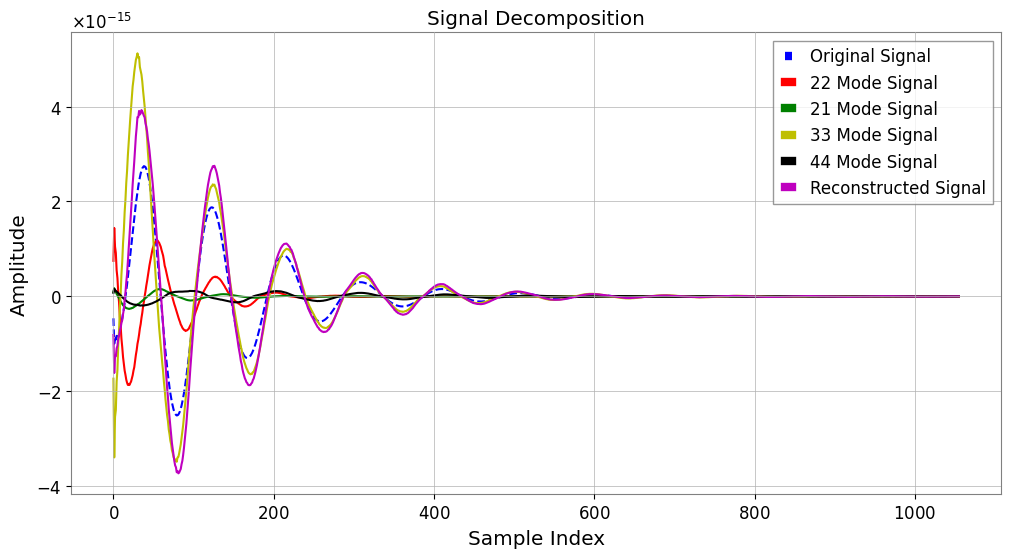

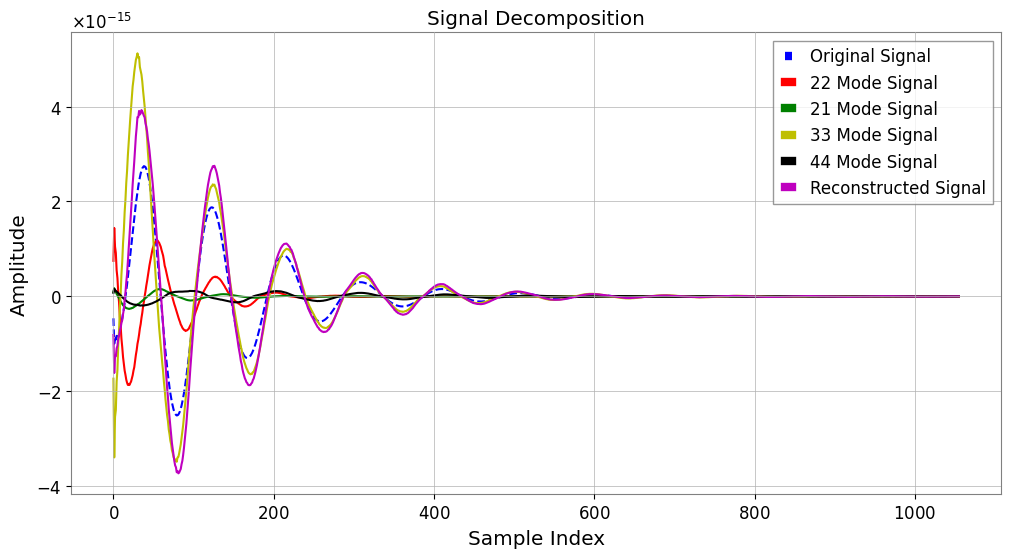

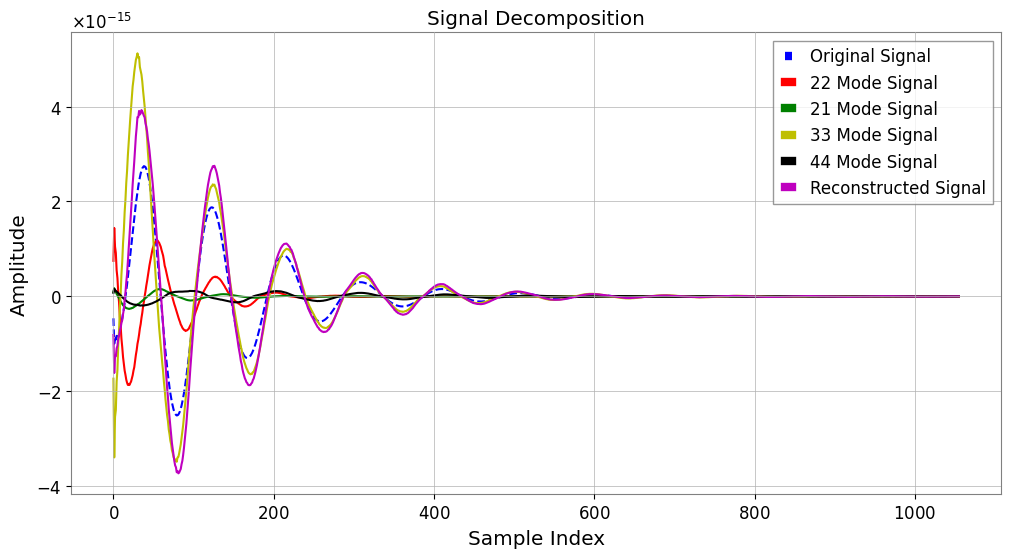

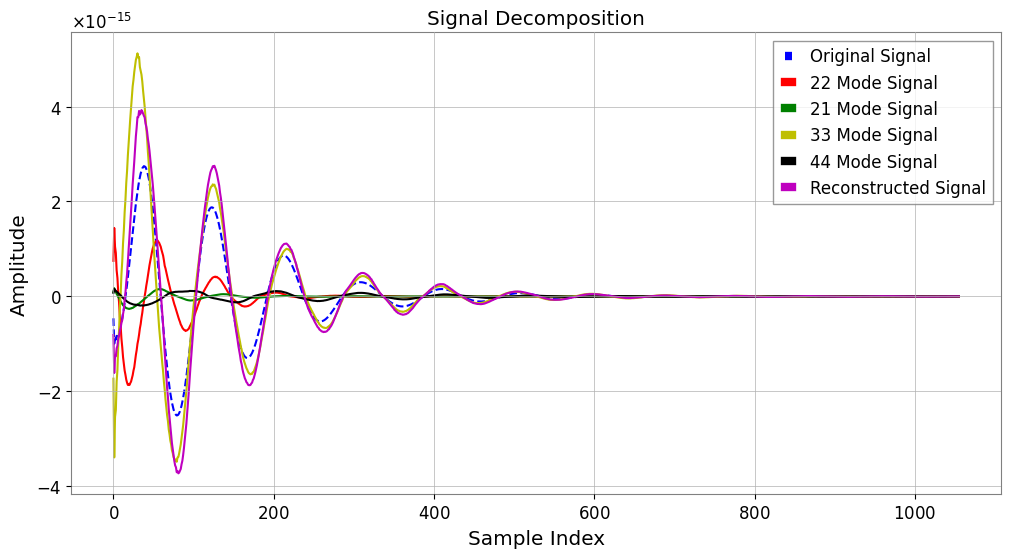

In [22]:
from utils.visualization import visualize_waveform_decomposition
with torch.no_grad():
    outputs = model(processed_test_signals_tensor)
    outputs_split = torch.split(outputs, 1, dim=1)
    modes = [mode.to(device).squeeze(1) for mode in outputs_split] 
#    initial_reconstructed_signals = mean_t+std_t*reconstructed_signals_tensor.cpu().squeeze(-1).numpy()
# for i in range(5):
#     print(f"Signal {i}:")
#     print("Original signal contains NaN:", torch.isnan(torch.tensor(n_test_signals[i])).any())
#     print("Masked signal contains NaN:", torch.isnan(torch.tensor(masked_test_signals_tensor.cpu().numpy()[i])).any())
#     print("Reconstructed signal contains NaN:", torch.isnan(torch.tensor(initial_reconstructed_signals[i])).any())

#     print("Original signal contains Inf:", torch.isinf(torch.tensor(n_test_signals[i])).any())
#     print("Masked signal contains Inf:", torch.isinf(torch.tensor(masked_test_signals_tensor.cpu().numpy()[i])).any())
#     print("Reconstructed signal contains Inf:", torch.isinf(torch.tensor(initial_reconstructed_signals[i])).any())

#     # 如果没有NaN或者Inf，才进行可视化
#     if not (torch.isnan(torch.tensor(n_test_signals[i])).any() or
#             torch.isnan(torch.tensor(masked_test_signals_tensor.cpu().numpy()[i])).any() or
#             torch.isnan(torch.tensor(initial_reconstructed_signals[i])).any() or
#             torch.isinf(torch.tensor(n_test_signals[i])).any() or
#             torch.isinf(torch.tensor(masked_test_signals_tensor.cpu().numpy()[i])).any() or
#             torch.isinf(torch.tensor(initial_reconstructed_signals[i])).any()):
#         visualize_waveform(
#             n_test_signals[i],
#             masked_test_signals_tensor.cpu().numpy()[i],
#             initial_reconstructed_signals[i],
#             title=f'Initial Reconstruction {i+1}'
#         )
#     else:
#         print(f"Signal {i} contains NaN or Inf, skipping visualization.")
# for i in range(5):
#     print(f"Signal {i}:")
#     print(f"Original signal min: {n_test_signals[i].min()}, max: {n_test_signals[i].max()}")
#     print(f"Masked signal min: {masked_test_signals_tensor.cpu().numpy()[i].min()}, max: {masked_test_signals_tensor.cpu().numpy()[i].max()}")
#     print(f"Reconstructed signal min: {initial_reconstructed_signals[i].min()}, max: {initial_reconstructed_signals[i].max()}")
#print(masks.size(),test_signals.size())
#test_masked_signals=masks.cpu().numpy()*test_signals.cpu().numpy()
#print(masked_test_signals)
# 可视化初步复原结果
std_0=std_0.cpu().numpy()
mean_0=mean_0.cpu().numpy()
std_22=std_22.cpu().numpy()
mean_22=mean_22.cpu().numpy()
std_21=std_21.cpu().numpy()
mean_21=mean_21.cpu().numpy()
std_33=std_33.cpu().numpy()
mean_33=mean_33.cpu().numpy()
std_44=std_44.cpu().numpy()
mean_44=mean_44.cpu().numpy()

print(type(test_signals.cpu().numpy()))

modes = [mode.cpu().numpy() for mode in modes]
modes[0]=modes[0]*std_22+mean_22
modes[1]=modes[1]*std_21+mean_21
modes[2]=modes[2]*std_33+mean_33
modes[3]=modes[3]*std_44+mean_44
for i in range(5):
    visualize_waveform_decomposition(
        (test_signals_copy[i].cpu().numpy() )*std_0+mean_0,
        modes[0][i],
        modes[1][i],
        modes[2][i],
        modes[3][i],
        (modes[0][i]+modes[1][i]+modes[2][i]+modes[3][i])
        #title=f'Initial Reconstruction {i+1}'
        )

    # 参数估计
# estimated_conditions = []
# for i in range(reconstructed_signals_tensor.size(0)):
#     estimated_params = test_conditions[i]
#     estimated_conditions.append(estimated_params)
# #estimated_conditions_tensor = torch.tensor(estimated_conditions, dtype=torch.float32).to(device)
# estimated_conditions_tensor = torch.tensor(np.array(estimated_conditions), dtype=torch.float32).to(device)

# # 第二次复原：使用估计的条件输入
# with torch.no_grad():
#     final_reconstructed_signals_tensor = model(
#         test_signals_tensor,
#         masks,
#         estimated_conditions_tensor,  # 使用估计的条件输入
#         gap_start
#         )
#     final_reconstructed_signals = final_reconstructed_signals_tensor.cpu().squeeze(-1).numpy()
#     final_reconstructed_signals= std_t*final_reconstructed_signals+mean_t
# # 可视化最终复原结果
# for i in range(5):
#     visualize_waveform(
#         test_signals[i],
#         masked_test_signals[i],
#         final_reconstructed_signals[i],
#         title=f'Final Reconstruction with Estimated Conditions {i+1}'
#         )

In [ ]:
int 1

SyntaxError: invalid syntax (89991222.py, line 1)

In [ ]:
from utils.normalize import normalize
signal=[   ]
a=np.arange(0,11,1)
b=np.arange(0,22,2)
signal.append(a)
signal.append(b)
signal=torch.tensor(signal)
signal = signal.float()
normalized_signal ,mean,std=normalize(signal)


print(normalized_signal)
print(mean)

tensor([[    nan, -0.7071, -0.7071, -0.7071, -0.7071, -0.7071, -0.7071, -0.7071,
         -0.7071, -0.7071, -0.7071],
        [    nan,  0.7071,  0.7071,  0.7071,  0.7071,  0.7071,  0.7071,  0.7071,
          0.7071,  0.7071,  0.7071]])
tensor([ 0.0000,  1.5000,  3.0000,  4.5000,  6.0000,  7.5000,  9.0000, 10.5000,
        12.0000, 13.5000, 15.0000])


/home/ljq/code/Ringdown_gap_filling/Proj/utils/normalize.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  signal=torch.tensor(signal)


In [ ]:
import torch

# 假设你的信号数据组是一个二维张量，形状为 (num_signals, signal_length)
# 例如，100个信号，每个信号长度为1000
signals = torch.rand(100, 1000)  # 生成一些随机信号作为示例

# 计算平均信号
mean_signal = signals.mean(dim=0)

# 计算方差信号
std_signal = signals.std(dim=0)

# 对信号进行归一化（减去均值后除以标准差）
normalized_signals = (signals - mean_signal) / std_signal

print("平均信号:", mean_signal.shape)
print("方差信号:", std_signal.shape)


平均信号: torch.Size([1000])
方差信号: torch.Size([1000])


In [ ]:
import torch

# 假设 batch_size=32，seq_len=1000
batch_size = 32
seq_len = 10
gap_size = 2

# 假设 gap_start 是长度为 batch_size 的张量，其中包含每个序列的掩码起始索引
gap_start = torch.randint(0, seq_len - gap_size, (batch_size,))

# 初始化输出张量
output = torch.zeros((batch_size, seq_len, 1))

# 通过广播机制构造索引
row_indices = torch.arange(batch_size).unsqueeze(1)  # [batch_size, 1]
gap_indices = gap_start.unsqueeze(1) + torch.arange(gap_size).unsqueeze(0)  # [batch_size, gap_size]

# 将 1 分配到输出张量中的指定位置
output[row_indices, gap_indices] = 1
print(gap_start,output)

tensor([7, 1, 5, 2, 0, 1, 5, 6, 7, 7, 2, 7, 7, 1, 0, 1, 5, 7, 5, 2, 4, 6, 5, 4,
        1, 3, 1, 0, 1, 4, 6, 5]) tensor([[[0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [1.],
         [1.],
         [0.]],

        [[0.],
         [1.],
         [1.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [1.],
         [1.],
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [1.],
         [1.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.]],

        [[1.],
         [1.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.]],

        [[0.],
         [1.],
         [1.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
       

In [ ]:
# import torch
# import matplotlib.pyplot as plt
# from torch.utils.data import DataLoader

# from config.config import Config
# from data.data_generation import generate_varied_sinusoidal_data
# from dataset.dataset import GWSignalDataset
# from model.autoencoder import MaskedConditionalAutoencoder
# from utils.visualization import visualize_waveform

# def main():
#     # 生成测试集数据（包括真实的振幅、频率和相位）
#     test_signals, masked_test_signals, test_conditions = generate_varied_sinusoidal_data(
#         num_samples=5,  # 例如 5 个测试样本
#         signal_length=Config.signal_length,
#         gap_size=Config.gap_size
#     )

#     # 转换为张量并确保维度正确
#     test_signals_tensor = torch.tensor(test_signals, dtype=torch.float32).unsqueeze(-1).to(device)
#     masked_test_signals_tensor = torch.tensor(masked_test_signals, dtype=torch.float32).unsqueeze(-1).to(device)
#     test_conditions_tensor = torch.tensor(test_conditions, dtype=torch.float32).to(device)

#     # 加载训练好的模型
#     model = MaskedConditionalAutoencoder(
#         input_dim=1,  # 信号的特征维度
#         hidden_dim=Config.hidden_dim,
#         num_layers=Config.num_layers,
#         condition_dim=Config.condition_dim,
#         gap_size=Config.gap_size
#     ).to(device)

#     model.load_state_dict(torch.load(Config.model_save_path))
#     model.eval()  # 设置模型为评估模式

#     # 使用真实参数进行复原
#     with torch.no_grad():
#         reconstructed_signals_tensor = model(
#             masked_test_signals_tensor,
#             torch.ones_like(masked_test_signals_tensor).to(device),
#             test_conditions_tensor  # 使用真实的条件输入
#         )
#         reconstructed_signals = reconstructed_signals_tensor.cpu().squeeze(-1).numpy()

#     # 可视化结果
#     for i in range(5):
#         visualize_waveform(
#             test_signals[i],
#             masked_test_signals[i],
#             reconstructed_signals[i],
#             title=f'Test Signal Reconstruction {i+1} with Real Parameters'
#         )

# if __name__ == "__main__":
#     # 检查是否有可用的GPU
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     print(f'Using device: {device}')

#     main()
